In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2,baselinish3

from cs231n.data_utils import load_CIFAR10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


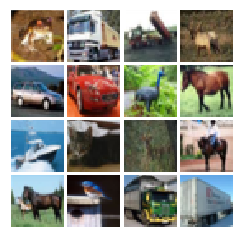

In [45]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
show_images(X_train[:16])

In [31]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha*x,x)

In [32]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    return D_solver, G_solver

In [33]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = 0.5*tf.reduce_mean(tf.square(score_fake-1))
    D_loss = 0.5*tf.reduce_mean(tf.square(score_real-1) + tf.square(score_fake))
    return D_loss, G_loss

In [34]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        #reshaped_x = tf.transpose(x,perm = [0,2,3,1])
        reshaped_x = x
        a1 = tf.layers.conv2d(reshaped_x,filters = 32,kernel_size = [5,5],activation = leaky_relu)
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [5,5],activation = leaky_relu)
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.reshape(a1,shape=[-1,5*5*64])
        a1 = tf.layers.dense(a1,5*5*64,activation = leaky_relu)
        logits = tf.layers.dense(a1,1)
        
        
        return logits

In [46]:
def generator(X):
    
    with tf.variable_scope("generator"):
        Float_image = X
        conv_mat = tf.constant(np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],[0.615,-0.514999,-0.10001]]),dtype = tf.float32)
        inv_conv_mat = tf.constant(np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]]),dtype = tf.float32)

        Float_image = tf.reshape(Float_image,[-1,3])

        YUV_image = tf.matmul(Float_image,conv_mat)
        YUV_image = tf.reshape(YUV_image,[-1,32,32,3])
        Float_image = tf.reshape(Float_image,[-1,32,32,3])
        UV_p = YUV_image[:,:,:,1:3]
        Y_p = YUV_image[:,:,:,0:1]

        a1 = tf.layers.conv2d(Y_p,filters = 32,kernel_size = [5,5],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [5,5],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 2,kernel_size = [1,1],activation = tf.tanh,padding = 'same')



        a3 = tf.concat((Y_p,a1),axis = 3)
        #a2 = tf.image.hsv_to_rgb(a3)
        a3 = tf.reshape(a3,[-1,3])
        a2 = tf.matmul(a3,inv_conv_mat)
        RGB_out = tf.reshape(a2,[-1,32,32,3])

    
    return RGB_out

In [47]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32,32,3])
#z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [57]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=10, print_every=5, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(50000*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            rand_indices = np.random.choice(np.arange(49000),batch_size)
            minibatch = X_train[rand_indices]
            samples = sess.run(G_sample,feed_dict = {x:minibatch})
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        #minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        rand_indices = np.random.choice(np.arange(49000),batch_size)
        minibatch = X_train[rand_indices]
        #print(minibatch.dtype)
        #print (minibatch.shape)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x:minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

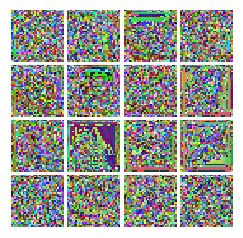


Iter: 0, D: 0.8587, G:33.2
Iter: 5, D: 0.559, G:0.6066


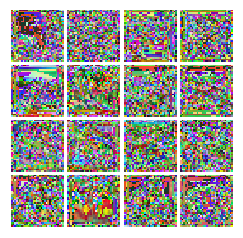


Iter: 10, D: 0.3296, G:0.3698
Iter: 15, D: 0.2273, G:0.3916


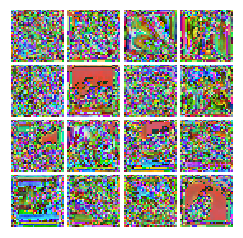


Iter: 20, D: 0.05679, G:0.442
Iter: 25, D: 0.03646, G:0.467


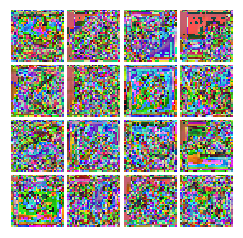


Iter: 30, D: 0.04022, G:0.4754
Iter: 35, D: 0.0714, G:0.427


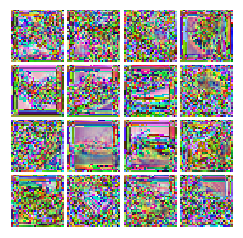


Iter: 40, D: 0.1564, G:0.6284
Iter: 45, D: 0.1486, G:0.3724


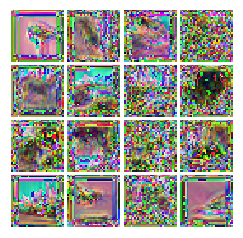


Iter: 50, D: 0.09092, G:0.4781
Iter: 55, D: 0.1048, G:0.2877


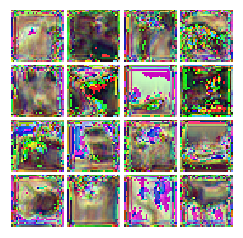


Iter: 60, D: 0.1005, G:0.3869


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)